In [2]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.providers.ibmq import least_busy
import numpy as np
import math

In [3]:
IBMQ.load_accounts()

In [15]:
class DustCircuit(QuantumCircuit):
    def __init__(self, n_states, t, freq):
        n = math.ceil(math.log(n_states,2))
        self.q = QuantumRegister(n)
        self.c = ClassicalRegister(n)
        self.dict_results = None
        self.statevector = None
        self.result = None        
        super().__init__(self.q,self.c)    
        coefs = DustCircuit._generate_coefs(n_states, t, freq)
        self.initialize(coefs, self.q)
    def simulate(self, nshots = 1000,backend=BasicAer.get_backend('qasm_simulator')):
        self.result = execute(self, backend, shots=nshots).result()        
        self.counts = self.result.get_counts(self)
        self.dict_results = {}
        for key in list(self.counts.keys()):
            self.dict_results[int(key,2)] = self.counts[key]
        return self.result
    def simulate_statevector(self):
        self.result = execute(self, BasicAer.get_backend('statevector_simulator')).result()
        self.statevector = self.result.get_statevector(self)
        return self.result
    def execute(self, nshots = 1000, max_credits=3):
        large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits < 10 and
                                                       not x.configuration().simulator)
        backend = least_busy(large_enough_devices)
        self.result = execute(self, backend, shots=nshots, max_credits=max_credits).result()
        self.counts = self.result.get_counts(self)
        self.dict_results = {}
        for key in list(self.counts.keys()):
            self.dict_results[int(key,2)] = self.counts[key]
        return self.result
    def plot(self, how='histogram'):
        fig = None
        if (how == 'histogram'): fig = \
         plot_histogram(self.dict_results)
        elif (how == 'state_city'): fig = \
         plot_state_city(self.statevector)
        return fig    
    def exec_and_simulate(self, nshots = 1000, sim_backend = BasicAer.get_backend('qasm_simulator'), credits=3):
        self.simulate(nshots, backend=sim_backend)
        sim_results = self.dict_results        
        self.execute(nshots, max_credits=credits)
        self.dict_results = [sim_results, self.dict_results]        
    @staticmethod
    def _generate_coefs(tam, t, freq):
        h, kB = 6.582119624 * 10**(-16), 8.6173324*10**(-5) #ctes    
        E = [h*freq*(i+1/2) for i in range(tam)]
        cNumerador = [math.exp(-E[i]/(kB*t)) for i in range(tam)]     
        sumDenom = math.sqrt(sum(cNumerador))
        c = [math.sqrt(cNumerador[i])/sumDenom for i in range(tam)]
        return c

In [23]:
t, freq = 15*10**9, 1.55*10**21 
c = DustCircuit(4, t, freq)
c.crz(2*math.pi, c.q[0], c.q[1])
c.measure(c.q, c.c)
c.exec_and_simulate()


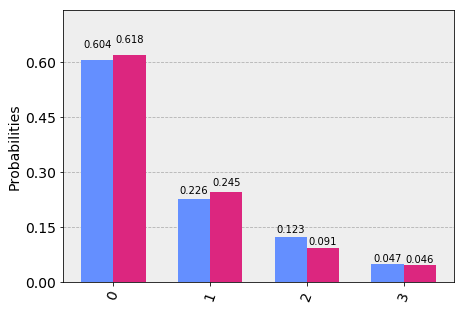

In [24]:
c.plot()

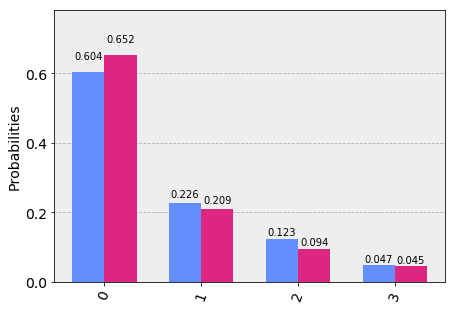

In [19]:
c.plot()

In [5]:

def matrizDensidad(tam, t, freq): #tam 4, estados 0 a 3
    h, kB = 6.582119624 * 10**(-16), 8.6173324*10**(-5) #ctes    
    E = [h*freq*(i+1/2) for i in range(tam)]
    #E = [-13.6, -9.37,-5.14,-0.9]
    
    cNumerador = [math.exp(-E[i]/(kB*t)) for i in range(tam)] 
    print(cNumerador)
    sumDenom = math.sqrt(sum(cNumerador))
    print(sumDenom)
    c = [math.sqrt(cNumerador[i])/sumDenom for i in range(tam)]
    
    
    #c[tam-1] = 1 - sum([math.sqrt(cNumerador[i])/sumDenom for i in range(tam)])
    
    print(c)
    m = np.matrix([[c[i]*c[j] for j in range(tam)] for i in range(tam)])
    return (m,c)


NameError: name 'coeficiente' is not defined

In [8]:
t, freq = 15*10**10, 1.55*10**21 
c = DustCircuit(4, t, freq)
c.measure(c.q, c.c)
#c.exec_and_show()
#large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits < 10 and
#                                                       not x.configuration().simulator)
#backend = least_busy(large_enough_devices)
#job = execute(c, backend, shots=1000, max_credits=5)
#print (c)

In [ ]:
plot_histogram(job.result().get_counts())